In [1]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP, ABPR, GPR
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt

os.chdir('Behance')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('Behance_appreciate_1M', sep=' ', header=None)
    data.columns = ['user', 'item', 'timestamps']
    data = Data(data, users_on_val_test=5000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)
        
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim':0, 'lr':0, 'weight_decay':0}

Data prepared: 23971 users, 32489 items.
642875 train, 27459 validation and 27786 test interactions.


In [5]:
print('Average item popularity on training: {}'.format(data.item_support[data.train[:, 1]].mean()))
print('Average item popularity on validation: {}'.format(data.item_support[data.val[:, 1]].mean()))
print('Average item popularity on test: {}'.format(data.item_support[data.test[:, 1]].mean()))

Average item popularity on training: 148.06707058137275
Average item popularity on validation: 149.5865836337813
Average item popularity on test: 146.35388325055783


# logMF

In [ ]:
name = 'logMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5),
              'n_negative': trial.suggest_int('neg', 5, 50)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(name, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 3.6 M 
1 | item_embeddings | Embedding | 4.9 M 
----------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
34.102    Total estimated model params size (MB)
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/vcoscrato/Documents/RecSys/MF/tests/Behance/checkpoints/logMF exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[I 2022-04-11 14:36:27,649] Trial 3 finished with value: 0.01770610734820366 and parameters: {'bs': 9717, 'dim': 151, 'lr': 8.084495671810224e-05, 'wd': 0.0, 'neg': 36}. Best is trial 3 with value: 0.01770610734820366.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 2.4 M 
1 | item_embeddings | Embedding | 3.2 M 
----------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.358    Total estimated model params size

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# bprMF

In [3]:
name = 'bprMF'
def objective(trial):
    
    # Parameter setup
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    model = init_model(name, **params)
    loss, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('best_loss', loss)
    trial.set_user_attr('filename', path)
    return val_MAP(model, data)

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, use_baseline=False, name=name)

clear_output(wait=True)
print(results)
best_runs

{'Rating_rec': {'MAP': array([0.00024239, 0.0003809 , 0.0004617 , 0.00049632, 0.00051652,
       0.00055413, 0.00058876, 0.00059742, 0.00060896, 0.00060896]), 'Recall': array([3.70837000e-05, 1.31289661e-04, 1.77433078e-04, 2.25179505e-04,
       2.31474288e-04, 2.83646517e-04, 3.06576007e-04, 3.25006633e-04,
       3.40317304e-04, 3.94311454e-04])}}


,number,value,datetime_start,datetime_complete,duration,params_dim,params_lr,params_wd,user_attrs_best_loss,user_attrs_filename,state
10,10,0.011463,2022-03-04 00:22:47.059025,2022-03-04 00:27:14.022297,0 days 00:04:26.963272,104,0.000994,3.287610e-07,0.360408,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
3,3,0.011438,2022-03-03 23:37:40.656649,2022-03-03 23:42:45.005304,0 days 00:05:04.348655,111,0.000744,7.901823e-07,0.343975,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
11,11,0.011345,2022-03-04 00:27:14.023177,2022-03-04 00:32:09.224595,0 days 00:04:55.201418,101,0.000995,3.085020e-07,0.362852,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
13,13,0.011343,2022-03-04 00:37:08.798757,2022-03-04 00:43:12.325043,0 days 00:06:03.526286,115,0.000556,1.686514e-06,0.340145,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
0,0,0.011324,2022-03-03 23:20:36.067530,2022-03-03 23:26:23.669147,0 days 00:05:47.601617,53,0.000428,6.224463e-07,0.352081,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


({'URI_new': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unc_plot': <Figure size 432x288 with 2 Axes>,
  'FCP': 0.7625899834468953,
  'Pairs uncertainty': {'Concordant': -493.8955062645761,
   'Discordant': -570.0420612271371},
  'URI_vanilla': array([-0.47471565, -0.47244244, -0.48402424, -0.47421176, -0.47261377,
         -0.46963502, -0.4651659 , -0.46288846, -0.46319799, -0.46297352]),
  'Unc_MAP_corr': array([-0.03471172, -0.04440439, -0.04678047, -0.05328531, -0.05650612,
         -0.05961075, -0.06315802, -0.06379616, -0.06525019, -0.06425383])},
 {'URI_new': array([        nan, -0.06700763, -0.0789993 , -0.09300054, -0.06287995,
         -0.0323123 , -0.0314368 , -0.02563362, -0.02144413, -0.01127213]),
  'unc_plot': <Figure size 432x288 with 2 Axes>,
  'FCP': 0.7625899834468953,
  'Pairs uncertainty': {'Concordant': -138.5311714403982,
   'Discordant': -57.046309508366846},
  'URI_vanilla': array([3.4125128 , 3.1880983 , 2.96654097, 2.81008917, 2.73161811,
  

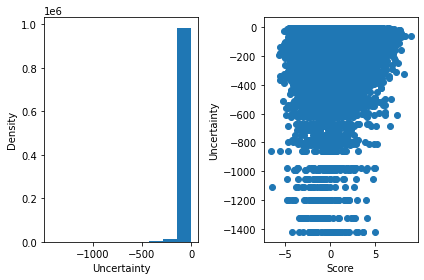

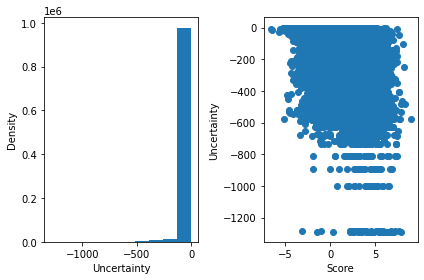

In [3]:
# Heuristics
model = load('bprMF', init_model('bprMF', **base_conf))
results0 = test(UserHeuristic(base_MF=model, uncertainty=-data.user.support.to_numpy()), data, max_k=10, use_baseline=True, name='User_support')
results1 = test(ItemHeuristic(base_MF=model, uncertainty=-data.item.support.to_numpy()), data, max_k=10, use_baseline=True, name='Item_support')
clear_output(wait=True)
results0, results1

# Ensemble

TypeError: only integer scalar arrays can be converted to a scalar index

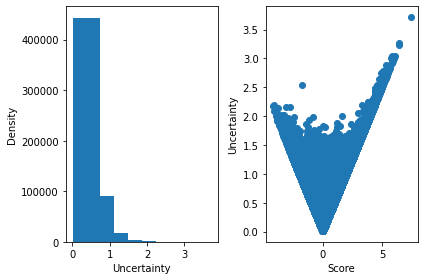

In [2]:
'''
study = run_study(name, n_trials=0)
for i in range(4):
    model = init_model(**study.best_params)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')
'''
models = [load('bprMF', init_model('bprMF', **base_conf))]
for file in os.listdir('checkpoints/ensemble'):
    models.append(init_model('bprMF', **base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
model = Ensemble(models)
results = test(model, data, name='Ensemble', max_k=10, use_baseline=False)
clear_output(wait=True)
print(results)

# Resample

In [4]:
data.item.loc[[0, 0, 1]]

,support
0,39.0
0,39.0
1,28.0


In [7]:
name = 'bprMF'
def init_model(dim=0, lr=0, wd=0):
    return bprMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd)

study = run_study(name, n_trials=0)

og = deepcopy(data.train)
for i in range(4):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = init_model(**study.best_params)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model(**study.best_params))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
model = Resample(load(name, init_model), models)
accuracy = test(model, data, name='Resample', max_k=10, use_baseline=False)['accuracy']
clear_output(wait=True)
print(accuracy)

{'Precision': array([0.00817203, 0.00718515, 0.00670614, 0.00644932, 0.00618442,
       0.00589817, 0.00580748, 0.00567454, 0.00555575, 0.00542955]), 'Recall': array([0.00339926, 0.00594146, 0.00832193, 0.01064719, 0.01282731,
       0.01451066, 0.0164312 , 0.01809544, 0.01978357, 0.02156343]), 'NDCG': array([0.00817203, 0.01195162, 0.01463988, 0.01695065, 0.01874658,
       0.02012953, 0.02174373, 0.02308615, 0.02436554, 0.02533395])}


# GPRMF (log)

In [2]:
name = 'biasGPRlog'
def init_model(dim=0, lr=0, wd=0):
    return biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=True))

def objective(trial):
    
    # Parameter setup
    dim = trial.suggest_int('dim', 50, 200)
    lr = trial.suggest_float('lr', 1e-4, 1e-3)
    wd = trial.suggest_float('wd', 1e-7, 1e-5)
    params = f'dim={dim}-wd={wd}-lr={lr}'

    # Train
    model = init_model(dim, lr, wd)
    loss, path = train(model, data, path='checkpoints/' + name, name=params)
    trial.set_user_attr('best_loss', loss)
    trial.set_user_attr('filename', path)
    return val_MAP(model, data)

study = run_study(name, objective, n_trials=0)
model = load(name, init_model)
accuracy = test(model, data, name=name, max_k=10, use_baseline=False)['accuracy']
clear_output(wait=True)
print(accuracy)
study.trials_dataframe().sort_values('value')[::-1][:5]

{'Precision': array([0.00692545, 0.00687351, 0.00646375, 0.00659649, 0.00648222,
       0.0062329 , 0.00603998, 0.005852  , 0.00565193, 0.00554728]), 'Recall': array([0.00258289, 0.00488914, 0.00685054, 0.00924531, 0.01115175,
       0.01284882, 0.01451341, 0.01581929, 0.01710624, 0.01832092]), 'NDCG': array([0.00692545, 0.01109829, 0.01367897, 0.01645933, 0.01863335,
       0.0202542 , 0.02171009, 0.02291887, 0.0240119 , 0.02513314])}


,number,value,datetime_start,datetime_complete,duration,params_dim,params_lr,params_wd,user_attrs_best_loss,user_attrs_filename,state
9,9,0.009526,2022-03-04 02:16:01.569469,2022-03-04 02:20:28.469305,0 days 00:04:26.899836,88,0.000589,7.056150e-06,0.399977,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
15,15,0.009392,2022-03-04 02:47:09.601271,2022-03-04 02:50:57.963480,0 days 00:03:48.362209,64,0.000399,1.257817e-06,0.419684,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
6,6,0.008685,2022-03-04 02:01:11.135955,2022-03-04 02:04:56.925491,0 days 00:03:45.789536,162,0.000560,3.551088e-07,0.444101,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
13,13,0.007856,2022-03-04 02:38:01.961548,2022-03-04 02:41:53.739055,0 days 00:03:51.777507,138,0.000369,1.093826e-07,0.444199,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
16,16,0.006735,2022-03-04 02:50:57.964274,2022-03-04 02:56:25.146455,0 days 00:05:27.182181,77,0.000102,3.690114e-06,0.450989,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# GPRMF (normal)

In [2]:
name = 'biasGPR'
def init_model(dim=0, lr=0, wd=0):
    return biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=False))

def objective(trial):
    
    # Parameter setup
    dim = trial.suggest_int('dim', 50, 200)
    lr = trial.suggest_float('lr', 1e-4, 1e-3)
    wd = trial.suggest_float('wd', 1e-7, 1e-5)
    params = f'dim={dim}-wd={wd}-lr={lr}'

    # Train
    model = init_model(dim, lr, wd)
    loss, path = train(model, data, path='checkpoints/' + name, name=params)
    trial.set_user_attr('best_loss', loss)
    trial.set_user_attr('filename', path)
    return val_MAP(model, data)

study = run_study(name, objective, n_trials=20)
model = load(name, init_model)
accuracy = test(model, data, name=name, max_k=10, use_baseline=False)['accuracy']
clear_output(wait=True)
print(accuracy)
study.trials_dataframe().sort_values('value')[::-1][:5]

{'Precision': array([0.00869144, 0.00753142, 0.00670614, 0.00625887, 0.00612902,
       0.00586932, 0.00572833, 0.00557499, 0.00548265, 0.00538107]), 'Recall': array([0.00357942, 0.00619427, 0.00815707, 0.0100698 , 0.01212275,
       0.01376862, 0.01544492, 0.01695315, 0.01844967, 0.0201303 ]), 'NDCG': array([0.00869144, 0.01260211, 0.0149438 , 0.01693895, 0.01894296,
       0.02041628, 0.02189965, 0.02317331, 0.02442117, 0.02553724])}


,number,value,datetime_start,datetime_complete,duration,params_dim,params_lr,params_wd,user_attrs_best_loss,user_attrs_filename,state
4,4,0.008731,2022-03-04 12:49:50.333468,2022-03-04 12:58:56.515428,0 days 00:09:06.181960,127,0.000674,0.000009,-0.733521,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
1,1,0.008158,2022-03-04 12:23:30.581272,2022-03-04 12:34:04.669339,0 days 00:10:34.088067,71,0.000976,0.000010,-0.726442,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
3,3,0.007962,2022-03-04 12:44:32.806253,2022-03-04 12:49:50.332650,0 days 00:05:17.526397,134,0.000551,0.000009,-0.712621,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
6,6,0.007904,2022-03-04 13:07:08.375386,2022-03-04 13:12:51.968986,0 days 00:05:43.593600,96,0.000286,0.000007,-0.726455,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
9,9,0.006590,2022-03-04 13:24:34.340756,2022-03-04 13:30:39.845464,0 days 00:06:05.504708,146,0.000371,0.000009,-0.714011,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# CAMF

In [3]:
name = 'CAMF'
def init_model(dim=0, lr=0, wd=0, neg=0):
    return CAMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, n_negative=neg)

def objective(trial):
    
    # Parameter setup
    dim = trial.suggest_int('dim', 50, 200)
    lr = trial.suggest_float('lr', 1e-5, 1e-3)
    wd = trial.suggest_float('wd', 1e-7, 1e-5)
    neg = trial.suggest_int('neg', 5, 50)
    params = f'dim={dim}-wd={wd}-lr={lr}-neg={neg}'

    # Train
    model = init_model(dim, lr, wd, neg)
    loss, path = train(model, data, path='checkpoints/' + name, name=params)
    trial.set_user_attr('best_loss', loss)
    trial.set_user_attr('filename', path)
    return val_MAP(model, data)

study = run_study(name, objective, n_trials=20)
model = load(name, init_model)
accuracy = test(model, data, name=name, max_k=10, use_baseline=False)['accuracy']
clear_output(wait=True)
print(accuracy)
study.trials_dataframe().sort_values('value')[::-1][:5]

{'Precision': array([0.00706396, 0.00618096, 0.0055519 , 0.00524603, 0.00518716,
       0.00512483, 0.00504074, 0.00492572, 0.00482858, 0.0047751 ]), 'Recall': array([0.00275485, 0.00508243, 0.00669918, 0.00829404, 0.01019557,
       0.01176891, 0.01338718, 0.01467429, 0.01623967, 0.01757207]), 'NDCG': array([0.00706396, 0.01034106, 0.01237728, 0.01415366, 0.01599312,
       0.01758424, 0.01895202, 0.02011651, 0.02118784, 0.02224447])}


,number,value,datetime_start,datetime_complete,duration,params_dim,params_lr,params_neg,params_wd,user_attrs_best_loss,user_attrs_filename,state
13,13,0.000157,2022-03-04 16:13:46.394212,2022-03-04 16:16:24.616758,0 days 00:02:38.222546,73,0.000986,26,0.000004,0.693147,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
15,15,0.000157,2022-03-04 16:20:52.830523,2022-03-04 16:23:13.343659,0 days 00:02:20.513136,50,0.000999,27,0.000006,0.693147,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
16,16,0.000157,2022-03-04 16:23:13.344621,2022-03-04 16:26:34.046440,0 days 00:03:20.701819,150,0.000692,9,0.000002,0.693147,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
17,17,0.000157,2022-03-04 16:26:34.047238,2022-03-04 16:29:22.126662,0 days 00:02:48.079424,72,0.000872,23,0.000004,0.693147,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
9,9,0.000157,2022-03-04 15:57:27.511005,2022-03-04 16:01:22.727458,0 days 00:03:55.216453,171,0.000578,20,0.000002,0.693147,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# Results

,NDCG,RRI,UncertainNDCG
CAMF,0.022244,-0.011919,NaN
Ensemble,NaN,NaN,NaN
Item support,NaN,NaN,NaN
Resample,0.025334,-0.004646,NaN
User support,NaN,NaN,NaN
biasGPR,0.025537,0.021480,0.026095
biasGPRlog,0.025133,-0.002884,0.026912
bprMF,NaN,NaN,NaN
logMF,NaN,NaN,NaN


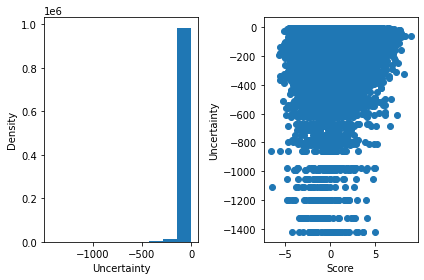

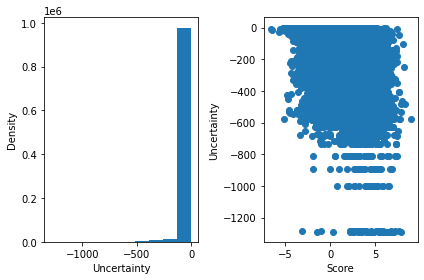

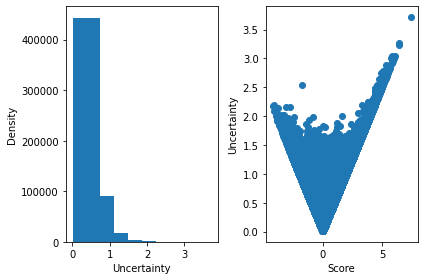

In [4]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results = dict(sorted(results.items()))
NDCG = [results[a]['accuracy']['NDCG'][-1] if 'accuracy' in results[a] else np.NaN for a in results]
RRI = [results[a]['uncertainty']['RRI'][-1] if 'uncertainty' in results[a] else np.NaN for a in results]
UncertainNDCG = [results[a]['uncertain_accuracy']['NDCG'][-1] if 'PR' in a else np.NaN for a in results]
interesting_stuff = pd.DataFrame({'NDCG': NDCG, 'RRI': RRI, 'UncertainNDCG': UncertainNDCG}, index=results)
interesting_stuff

In [7]:
results['Ensemble']

{'Precision': array([0.00914159, 0.00798158, 0.00713321, 0.00668306, 0.00640604,
        0.0062733 , 0.00614881, 0.00601215, 0.00591741, 0.00583815]),
 'Recall': array([0.00410262, 0.00735794, 0.00959558, 0.01182595, 0.0140198 ,
        0.01623699, 0.01816993, 0.01998148, 0.0216754 , 0.02384254]),
 'MAP': array([0.00914159, 0.01244849, 0.01417408, 0.01539085, 0.01632636,
        0.01710884, 0.017716  , 0.0181965 , 0.01859539, 0.01903139]),
 'NDCG': array([0.00914159, 0.01331444, 0.0159118 , 0.0180488 , 0.0199412 ,
        0.02172881, 0.02327073, 0.02464986, 0.0259391 , 0.02724817]),
 'URI_new': array([        nan, -0.09479893, -0.17574806, -0.1877541 , -0.19314086,
        -0.17980279, -0.18746716, -0.18854415, -0.18513186, -0.1827673 ]),
 'unc_plot': <Figure size 432x288 with 2 Axes>,
 'FCP': 0.7736536166608923,
 'Pairs uncertainty': {'Concordant': 1.8791402637631471,
  'Discordant': 1.5402538208533645},
 'URI_vanilla': array([-2.43858606, -2.35565883, -2.32699441, -2.3110895 , -2.296

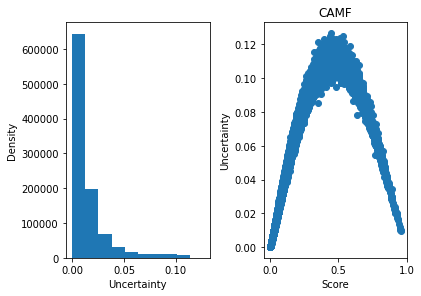

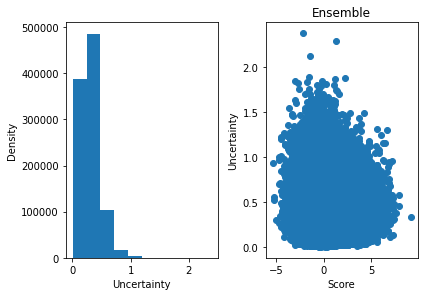

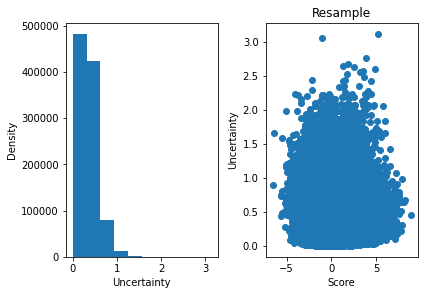

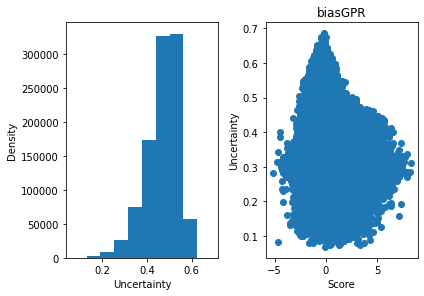

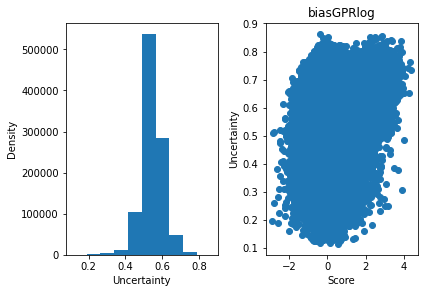

In [12]:
for key, value in results.items():
    if 'uncertainty' in value:
        unc_distribution(results=value)
        plt.title(key)

In [61]:
n_test = len(data.test)
positives = model(torch.tensor(data.test[:, 0]), torch.tensor(data.test[:, 1]))
negatives = model.get_negative_prediction(torch.tensor(data.test[:, 0]))
is_concordant = positives[0] - negatives[0] > 0
pairwise_unc = positives[1] + negatives[1]
loss = np.empty(n_test)
for i in range(n_test):
    p = positives[0][i], positives[1][i]
    n = negatives[0][i], negatives[1][i]
    loss[i] = model.loss_func(p, n)
print(f'FCP: {torch.sum(is_concordant) / n_test}')
print(f'Avg pairwise uncertainty concordant: {pairwise_unc[is_concordant].mean()}; discordant: {pairwise_unc[~is_concordant].mean()}')

FCP: 0.7763097882270813
Avg loss concordant: -0.9042988055329131; discordant: -0.20305634283158655
Avg pairwise uncertainty concordant: 0.7118403911590576; discordant: 0.6525160074234009


- [X] Check if all models in explicit case are outputting uncertainty properly. 

- [X] BeMF should not borrow the uncertainty metric from the rating case into the recommendation case / BeMF could do simply 1 - P(r > 4) as uncertainty. This would make uncertainty inversely proportional to relevance, but does the absolute values of the numbers still add something?

- [X] Also think about the absolute uncertainty numbers for the other models. Vanilla RRI might be the answer.

- [X] Check giovanni's paper experiment description (especially the early stopping part). There, they use MAP for early stopping as well, which removes the need of negative samples but increase the computational cost. They do validation check every 5 epochs. Their batch size also varies and is sometimes really small, which means that 5 epochs may consist of lots and lots of updates.

## RRI formulation

- Original: $$ \frac{\rho_{ui} - \bar{\rho}}{\sigma_\rho} $$
- Ours: $$ \frac{\rho_{ui} - \bar{\rho_u}}{\sigma_{\rho_u}} $$

We aknowledged that the original form has the problem of penalizing correct recommendations every time that their uncertainty is higher than the average uncertainty. For this reason we changed to the user based form, in which the uncertainties are compared to the user average uncertainty, and therefore a penalty to the RRI value occurs only if the uncertainty of the correct recommendation is higher than the average uncertainty for the user.

Nevertheless, our formulation does not analyze the recommendation in a cross-user aspect. Ideally, if uncertainty is well defined, than we want the recommendation hits to a user to be those with the lowest uncertainty among the recommendations to that user, and also the most precise recommendation sets to be given to the user with the lowest average uncertaity.